In [195]:
#Import Libraries
!pip install wordcloud
!pip install plotly
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
import plotly.express as px
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')

!pip install unidecode
import unidecode

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kylielee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kylielee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [436]:
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import matplotlib.animation as animation
import operator
from collections import Counter

def dfCleaning(df):

    #import pandas_profiling

    #df = df[['text','retweet_count','favorite_count']]
    df.drop_duplicates(inplace = True)
    #Lowercase
    df['clean_tweet']= df['text'].apply(lambda x : x.lower())
    #Code to remove https
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    #Code to remove @
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([tweet for tweet in x.split()if not tweet.startswith("@")]))
    #Removing numbers
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([tweet for tweet in x.split() if not tweet == '\d*']))
    #Removing all the greek characters using unidecode library
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([unidecode.unidecode(word) for word in x.split()])) 
    #Removing the word 'hmm' and it's variants
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([word for word in x.split() if not word == 'h(m)+' ]))
    #Code for removing slang words
    d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
                   'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
                   'cud':'could','fud':'food','gal':'girl'} ## Need a huge dictionary
    words = "I luv myself"
    words = words.split()
    reformed = [d[word] if word in d else word for word in words]
    reformed = " ".join(reformed)
    
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join(d[word] if word in d else word for word in x.split()))
    
    #Finding words with # attached to it
    df['#'] = df['clean_tweet'].apply(
        lambda x : ' '.join([word for word in x.split() if word.startswith('#')]))
    frame = df['#']
    frame = pd.DataFrame(frame)
    frame = frame.rename({'#':'Count(#)'},axis = 'columns')
    frame[frame['Count(#)'] == ''] = 'No hashtags'
    data_frame = pd.concat([df,frame],axis = 1)
    data_frame.drop('#',axis = 1,inplace = True)
    
    #Column showing whether the corresponding tweet has a hash tagged word or not
    data_frame = data_frame.rename({'Count(#)':'Hash words'},axis = 'columns')

    #Removing stopwords
    data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(
        lambda x : ' '.join([word for word in x.split() 
                             if word not in set(stopwords.words('english')) and len(word) > 3]))
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    #data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(
        lambda x : ' '.join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in nltk.pos_tag(x.split())]))

    #Code to remove punctuation
    data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : re.sub('[%s]' % re.escape(string.punctuation),'',str(x)))
    
    #Stemming
    #ps = PorterStemmer()
    #adwait = data_frame
    #data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))
    #reset index
    data_frame.reset_index(drop=True, inplace=True)
        
    return data_frame

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kylielee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kylielee/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /Users/kylielee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [386]:
#Load EU data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vSg_vnBwkfqqbrFqPI_IKmGyP2tJ6bz-LKOpRhQAZGXOZ8yIUsp_Cd-z2pgOqj4oA8-Lx9jIHsiZga7/pub?output=csv"
EU_df = pd.read_csv(data_path)
EU_df.shape

(1270, 172)

In [197]:
#Load NA data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vR5olDTffDv6ug1khmNLEOcmRwR-RbnydRFEdUtcdBNjwhJODbe49aFIfCrKcq2lO2xEThirDuCBpqj/pub?output=csv"
NA_df = pd.read_csv(data_path)
NA_df.shape

(587, 163)

In [198]:
#Load Asia data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vQskpSOD62Y6uXOVKDU5OE7Nb12c__ZPOY68IZUSdeR1cWGrUmhC0qjUVFf_i-BJIKyzn8IxDsIfY5S/pub?output=csv"
AS_df = pd.read_csv(data_path)
AS_df.shape

(421, 161)

**Europe Data**

In [387]:
EU_df.info()
EU_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Columns: 172 entries, Unnamed: 0 to user.withheld_in_countries
dtypes: bool(18), float64(34), int64(11), object(109)
memory usage: 1.5+ MB


,Unnamed: 0,contributors,coordinates,created_at,entities.hashtags,entities.media,entities.symbols,entities.urls,entities.user_mentions,extended_entities.media,...,user.profile_use_background_image,user.protected,user.screen_name,user.statuses_count,user.time_zone,user.translator_type,user.url,user.utc_offset,user.verified,user.withheld_in_countries
0,61dfc5708cef26fa7291f8d7,NaN,NaN,Thu Jan 13 03:41:46 +0000 2022,[],NaN,[],"[{""url"":""https://t.co/cLyuxZTDuZ"",""expanded_ur...",[],NaN,...,True,False,manny_alexandra,29963,NaN,none,https://t.co/Qbrvcx2mvp,NaN,False,[]
1,61dfc5708cef26fa7291f8d8,NaN,NaN,Thu Jan 13 03:08:25 +0000 2022,[],NaN,[],[],"[{""screen_name"":""TheAcademy"",""name"":""The Acade...",NaN,...,True,False,Mielzx,45165,NaN,regular,NaN,NaN,False,[]
2,61dfc5708cef26fa7291f8d9,NaN,NaN,Thu Jan 13 01:40:16 +0000 2022,[],NaN,[],[],[],NaN,...,True,False,cheesesocialist,23722,NaN,none,NaN,NaN,False,[]
3,61dfc5708cef26fa7291f8da,NaN,NaN,Thu Jan 13 00:46:15 +0000 2022,[],NaN,[],"[{""url"":""https://t.co/lIQg9OS4ZZ"",""expanded_ur...",[],NaN,...,False,False,KingLafs,141068,NaN,none,https://t.co/ZMXUBIAjoI,NaN,False,[]
4,61dfc5708cef26fa7291f8db,NaN,NaN,Thu Jan 13 00:24:42 +0000 2022,[],NaN,[],"[{""url"":""https://t.co/fLHDoAb23o"",""expanded_ur...",[],NaN,...,True,False,biggzbando516,1735,NaN,none,NaN,NaN,False,[]


In [480]:
EU_tweets = EU_df[['text','retweet_count','favorite_count']]

In [481]:
#Data cleaning
EU_Cleaned = dfCleaning(EU_tweets)

In [482]:
EU_Cleaned.head(10)

,text,retweet_count,favorite_count,clean_tweet,Hash words
0,This is a hate crime. https://t.co/cLyuxZTDuZ,0,0,hate crime,No hashtags
1,"@TheAcademy Cate Blanchett, or if she isn’t av...",0,0,cate blanchett available next best kate mckinn...,No hashtags
2,I haven't been kissed on kiss a ginger day so ...,0,0,kiss kiss ginger many year row hate crime,No hashtags
3,This is a hate crime https://t.co/lIQg9OS4ZZ,0,1,hate crime,No hashtags
4,This is a Hate Crime. Yuck https://t.co/fLHDoA...,0,0,hate crime yuck,No hashtags
5,why are the celebrities ignoring me today this...,0,2,celebrity ignore today hate crime,No hashtags
6,@bbceastenders I think story lines like this s...,0,0,think story line like air raise awareness culp...,No hashtags
7,Black Femicide stats are continuing to rise on...,16,34,black femicide stats continue rise daily basis...,No hashtags
8,@RogDangerfield @dhutchings91 lol that word ad...,0,0,word admission barmy makes sound like crime ps...,No hashtags
9,@metpoliceuk this is a hate crime https://t.co...,0,0,hate crime,No hashtags


**North America Data**

In [488]:
NA_tweets = NA_df[['text','retweet_count','favorite_count']]

In [489]:
NA_Cleaned = dfCleaning(NA_tweets)

In [490]:
NA_Cleaned.head(10)

,text,retweet_count,favorite_count,clean_tweet,Hash words
0,@sentinelvayne this is a hate crime,0,0,hate crime,No hashtags
1,@wedobeguaping no way she committed a hate cri...,0,1,commit hate crime,No hashtags
2,Cross Ts And Dot Is....fucking hate this phras...,0,1,cross isfucking hate phrase every actioncrime ...,No hashtags
3,Suspect in Waukesha Christmas Parade massacre ...,0,0,suspect waukesha christmas parade massacre fac...,No hashtags
4,NYC man accused of attacking man for wearing I...,0,0,accuse attack wear israel defense force hoodie...,No hashtags
5,@d_holter2 It's certainly looking that way. Wa...,0,0,certainly look way watch trail like watch trai...,No hashtags
6,@BlackKnight10k Hate and Crime….. takes up a l...,0,0,hate crime take time,No hashtags
7,Cop Who Killed Ashli Babbitt Was Cleared of Cr...,0,0,kill ashli babbitt clear criminal wrongdoing w...,No hashtags
8,@ThePlatypusCA @RubieGirlpwr69 @nobleloonlodge...,1,4,prof princess sound like hate crime t,No hashtags
9,I can't believe in WA State you can admit to b...,0,1,cant believe state admit party hate crime murd...,No hashtags


**Asia Data**

In [491]:
AS_tweets = AS_df[['text','retweet_count','favorite_count']]

In [492]:
AS_Cleaned = dfCleaning(AS_tweets)

In [493]:
AS_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words
0,@therealnaomib Don't hate the criminal.Hate th...,0,0,hate criminalhate crime,No hashtags
1,@vijaythottathil He should be charged under UA...,0,2,charge uapa hate speech muslim genocide congre...,No hashtags
2,Criminal crime minister\nWe hate\n#ForeignFund...,0,0,criminal crime minister hate foreignfundedcrim...,#foreignfundedcrimeminister
3,We should hate both crime and criminals. The o...,5,5,hate crime criminals make law talent killed he,No hashtags
4,@mr_mayank May be now he would be charged by t...,0,0,would charge government hate speech previous c...,No hashtags


**EDA**

*Tweet Count*

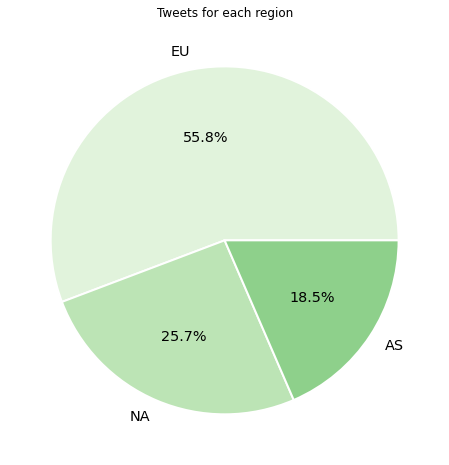

In [466]:
#count the total tweets of each dataframe
dataframes = {'EU': EU_Cleaned, 'NA': NA_Cleaned, 'AS': AS_Cleaned}
df_region = pd.DataFrame([(i, df.shape[0]) for i, df in dataframes.items()],
                            columns=['df','count_rows'])

#tweets for each region_plot
fig, ax = plt.subplots(figsize=(12,8))

labels = df_region['df']
colors = sns.color_palette("Greens")

ax.pie(df_region['count_rows'], labels=labels, colors=colors, autopct='%.1f%%',
       wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})
ax.set_title('Tweets for each region', fontsize=12)

plt.show()

*Retweet Count*

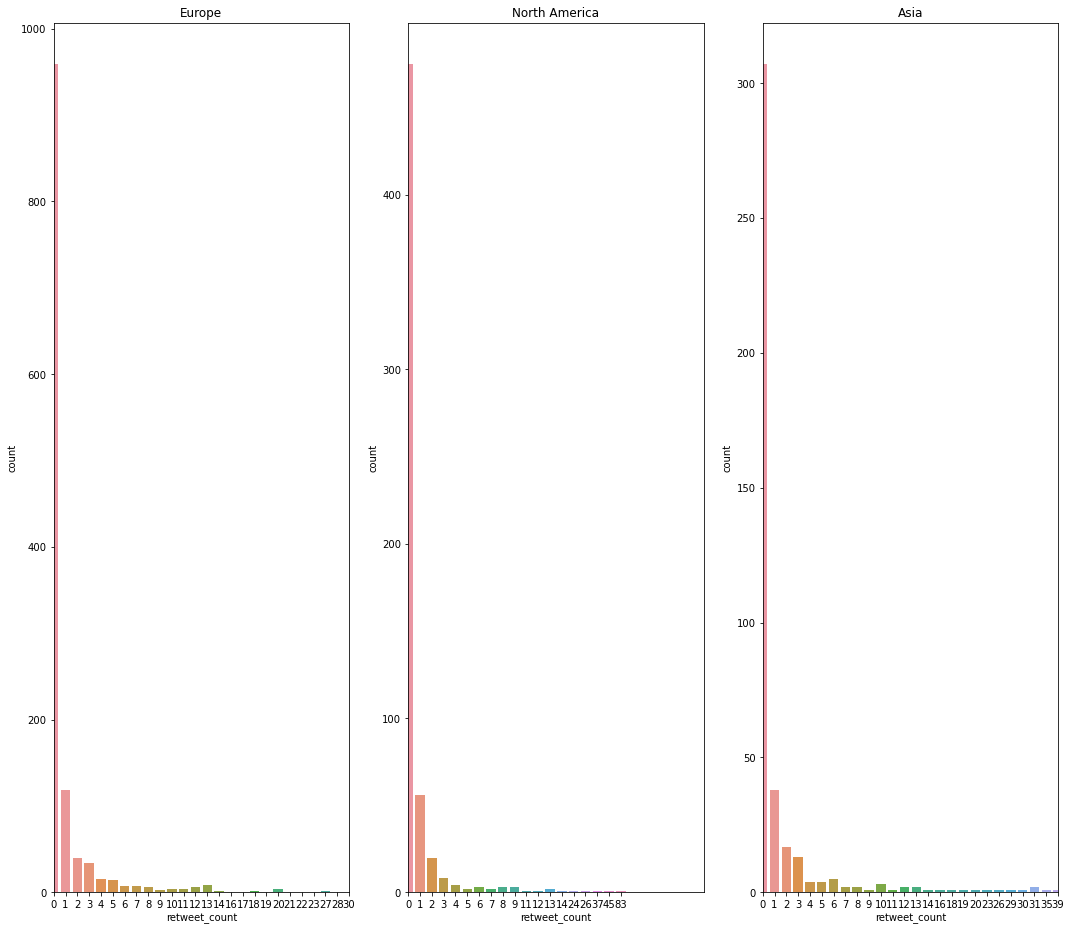

In [84]:
#retweet_count plots
fig, axs = plt.subplots(1,3, figsize=(18,16))

ax1=sns.countplot(x='retweet_count', data=EU_Cleaned, ax=axs[0])
ax1.set(title='Europe')
ax1.set_xlim([0, 25])

ax2=sns.countplot(x='retweet_count', data=NA_Cleaned, ax=axs[1])
ax2.set(title='North America')
ax2.set_xlim([0, 25])

ax3=sns.countplot(x='retweet_count', data=AS_Cleaned, ax=axs[2])
ax3.set(title='Asia')
ax3.set_xlim([0, 25])

plt.show()

*Favorite Count*

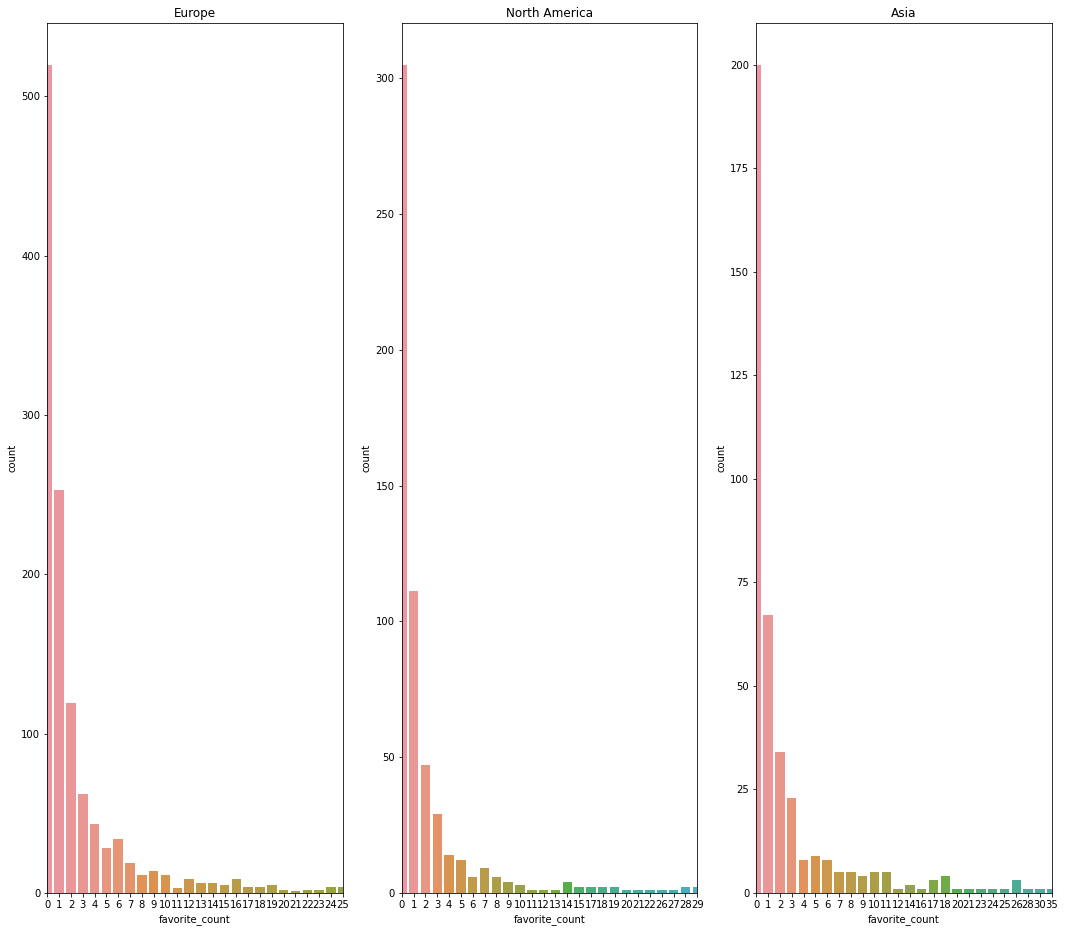

In [85]:
#favorite_count plots
fig, axs = plt.subplots(1,3, figsize=(18,16))

ax1=sns.countplot(x='favorite_count', data=EU_Cleaned, ax=axs[0])
ax1.set(title='Europe')
ax1.set_xlim([0, 25])

ax2=sns.countplot(x='favorite_count', data=NA_Cleaned, ax=axs[1])
ax2.set(title='North America')
ax2.set_xlim([0, 25])

ax3=sns.countplot(x='favorite_count', data=AS_Cleaned, ax=axs[2])
ax3.set(title='Asia')
ax3.set_xlim([0, 25])

plt.show()

*Most Common Words*

*EU*

In [483]:
#Most common words
EU_Cleaned['temp_list'] = EU_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in EU_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,hate,839
1,crime,817
2,statue,69
3,like,68
4,people,65
5,make,63
6,need,57
7,would,54
8,report,45
9,think,43


In [484]:
#Bar plot for most common words
fig = px.bar(temp, x="count", y="Common_words", title='EU: Commmon Words in Text', orientation='h', 
             width=700, height=600, color='Common_words')
fig.show()

*NA*

In [494]:
#Most common words
NA_Cleaned['temp_list'] = NA_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in NA_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,hate,421
1,crime,391
2,black,67
3,charge,63
4,attack,50
5,white,41
6,asian,39
7,like,33
8,people,28
9,murder,27


In [495]:
#Bar plot for most common words
fig = px.bar(temp, x="count", y="Common_words", title='NA: Commmon Words in Text', orientation='h', 
             width=700, height=600, color='Common_words')
fig.show()

*AS*

In [496]:
#Most common words
AS_Cleaned['temp_list'] = AS_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in AS_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,hate,303
1,crime,274
2,muslim,37
3,speech,26
4,people,26
5,amp,25
6,online,25
7,like,21
8,charge,18
9,say,17


In [497]:
#Bar plot for most common words
fig = px.bar(temp, x="count", y="Common_words", title='AS: Commmon Words in Text', orientation='h', 
             width=700, height=600, color='Common_words')
fig.show()

**Wordclouds**

In [498]:
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, **kwargs):
    return "hsl(%d, 80%%, 50%%)" % (360 * dictionary[word])
  return my_tf_color_func_inner

*EU*

Normal words


(-0.5, 799.5, 499.5, -0.5)

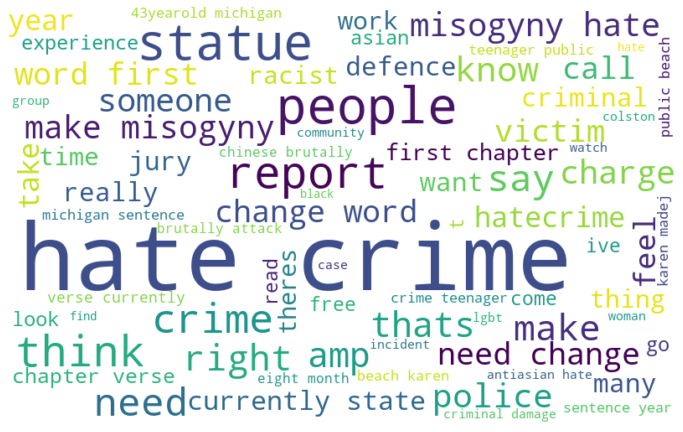

In [499]:
normal_words = ' '.join([word for word in EU_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

*NA*

Normal words


(-0.5, 799.5, 499.5, -0.5)

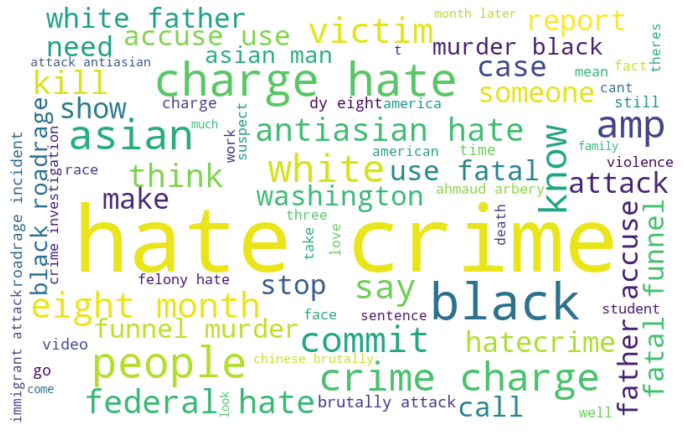

In [500]:
normal_words = ' '.join([word for word in NA_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

*AS*

Normal words


(-0.5, 799.5, 499.5, -0.5)

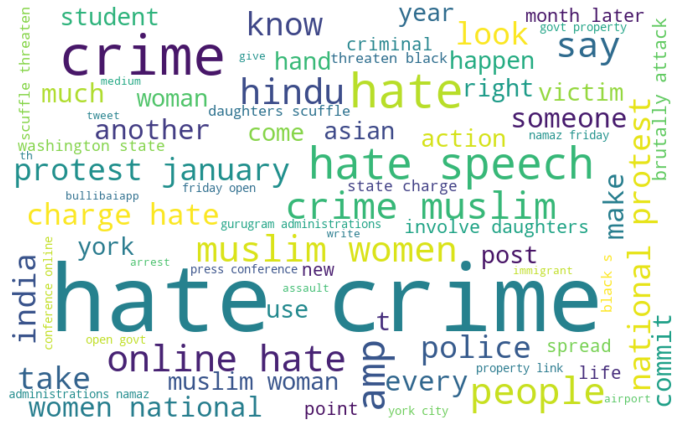

In [501]:
normal_words = ' '.join([word for word in AS_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

**Vader Sentiment Analysis**
- polarity
- subjectivity
- neg, neu, pos scores
- compound
-sentiment

*Europe*

In [502]:
#Europe
sia = SentimentIntensityAnalyzer()
EU_Cleaned[['polarity', 'subjectivity']] = EU_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(EU_Cleaned['text']):
  ps = sia.polarity_scores(s)
  EU_Cleaned.loc[index,['neg']] = ps['neg']
  EU_Cleaned.loc[index,['neu']] = ps['neu']
  EU_Cleaned.loc[index,['pos']] = ps['pos']
  EU_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    EU_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    EU_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    EU_Cleaned.loc[index,['sentiment']] = 'neutral'
   
EU_Cleaned.head(10)

,text,retweet_count,favorite_count,clean_tweet,Hash words,temp_list,polarity,subjectivity,neg,neu,pos,compound,sentiment
0,This is a hate crime. https://t.co/cLyuxZTDuZ,0,0,hate crime,No hashtags,"[hate, crime]",-0.800000,0.900000,0.706,0.294,0.000,-0.8020,negative
1,"@TheAcademy Cate Blanchett, or if she isn’t av...",0,0,cate blanchett available next best kate mckinn...,No hashtags,"[cate, blanchett, available, next, best, kate,...",0.150000,0.400000,0.245,0.612,0.143,-0.4588,negative
2,I haven't been kissed on kiss a ginger day so ...,0,0,kiss kiss ginger many year row hate crime,No hashtags,"[kiss, kiss, ginger, many, year, row, hate, cr...",-0.150000,0.700000,0.388,0.496,0.116,-0.7639,negative
3,This is a hate crime https://t.co/lIQg9OS4ZZ,0,1,hate crime,No hashtags,"[hate, crime]",-0.800000,0.900000,0.706,0.294,0.000,-0.8020,negative
4,This is a Hate Crime. Yuck https://t.co/fLHDoA...,0,0,hate crime yuck,No hashtags,"[hate, crime, yuck]",-0.800000,0.900000,0.643,0.357,0.000,-0.8020,negative
5,why are the celebrities ignoring me today this...,0,2,celebrity ignore today hate crime,No hashtags,"[celebrity, ignore, today, hate, crime]",-0.800000,0.900000,0.553,0.447,0.000,-0.8720,negative
6,@bbceastenders I think story lines like this s...,0,0,think story line like air raise awareness culp...,No hashtags,"[think, story, line, like, air, raise, awarene...",0.000000,0.000000,0.000,0.916,0.084,0.1901,positive
7,Black Femicide stats are continuing to rise on...,16,34,black femicide stats continue rise daily basis...,No hashtags,"[black, femicide, stats, continue, rise, daily...",-0.055556,0.144444,0.000,1.000,0.000,0.0000,neutral
8,@RogDangerfield @dhutchings91 lol that word ad...,0,0,word admission barmy makes sound like crime ps...,No hashtags,"[word, admission, barmy, makes, sound, like, c...",0.400000,0.400000,0.141,0.645,0.214,0.2023,positive
9,@metpoliceuk this is a hate crime https://t.co...,0,0,hate crime,No hashtags,"[hate, crime]",-0.800000,0.900000,0.643,0.357,0.000,-0.8020,negative


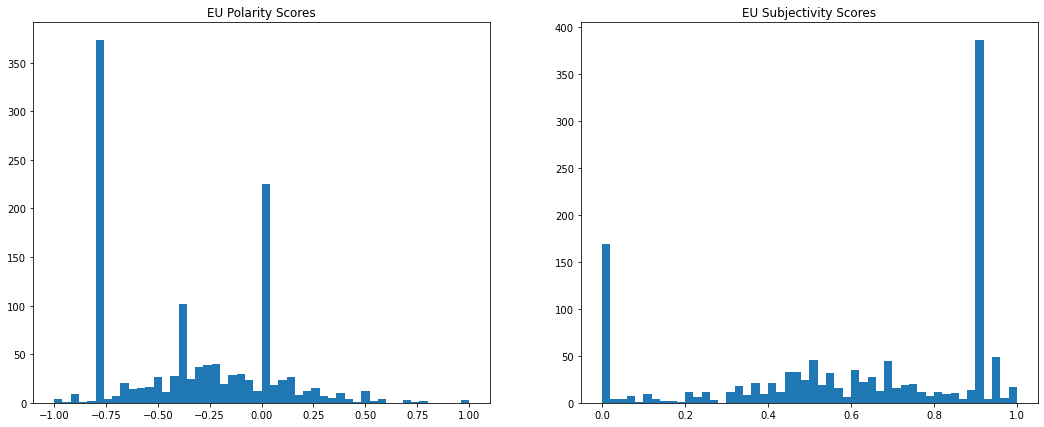

In [503]:
#EU Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(EU_Cleaned["polarity"], bins = n_bins)
ax1.set_title('EU Polarity Scores')
ax2.hist(EU_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('EU Subjectivity Scores')
plt.show()

[Text(0.5, 0, 'Europe Sentiment Result')]

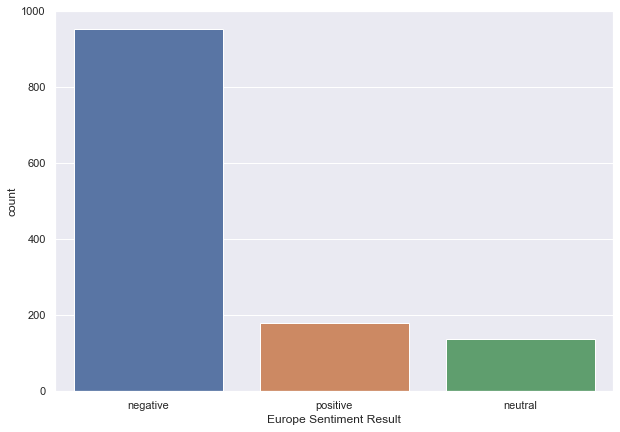

In [504]:
#EU Counterplot of sentiment
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=EU_Cleaned)
ax.set(xlabel='Europe Sentiment Result')

*North Amercia*

In [505]:
#North America
sia = SentimentIntensityAnalyzer()
NA_Cleaned[['polarity', 'subjectivity']] = NA_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(NA_Cleaned['text']):
  ps = sia.polarity_scores(s)
  NA_Cleaned.loc[index,['neg']] = ps['neg']
  NA_Cleaned.loc[index,['neu']] = ps['neu']
  NA_Cleaned.loc[index,['pos']] = ps['pos']
  NA_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    NA_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    NA_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    NA_Cleaned.loc[index,['sentiment']] = 'neutral'
   
NA_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words,temp_list,polarity,subjectivity,neg,neu,pos,compound,sentiment
0,@sentinelvayne this is a hate crime,0,0,hate crime,No hashtags,"[hate, crime]",-0.800,0.900000,0.706,0.294,0.000,-0.8020,negative
1,@wedobeguaping no way she committed a hate cri...,0,1,commit hate crime,No hashtags,"[commit, hate, crime]",-0.800,0.900000,0.570,0.303,0.127,-0.8074,negative
2,Cross Ts And Dot Is....fucking hate this phras...,0,1,cross isfucking hate phrase every actioncrime ...,No hashtags,"[cross, isfucking, hate, phrase, every, action...",-0.300,0.437500,0.147,0.754,0.099,-0.2960,negative
3,Suspect in Waukesha Christmas Parade massacre ...,0,0,suspect waukesha christmas parade massacre fac...,No hashtags,"[suspect, waukesha, christmas, parade, massacr...",-0.525,0.566667,0.511,0.489,0.000,-0.9118,negative
4,NYC man accused of attacking man for wearing I...,0,0,accuse attack wear israel defense force hoodie...,No hashtags,"[accuse, attack, wear, israel, defense, force,...",-0.800,0.900000,0.562,0.390,0.049,-0.9413,negative


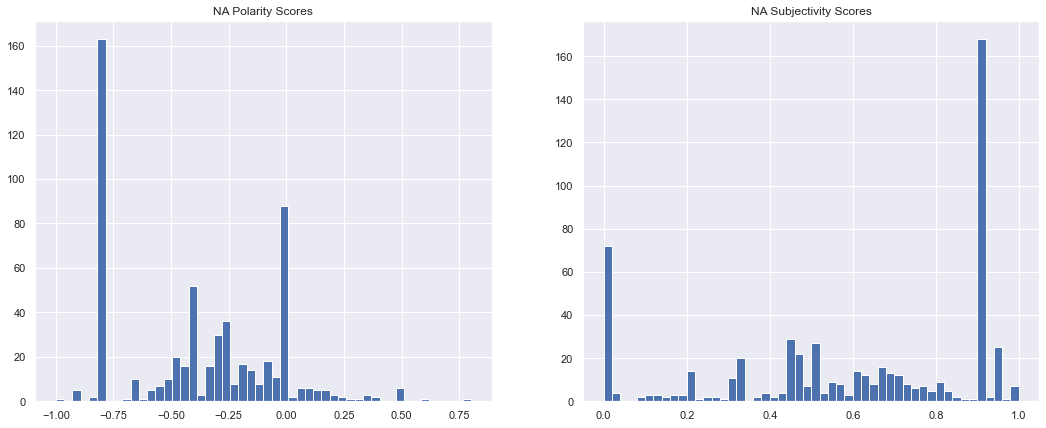

In [506]:
#NA Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(NA_Cleaned["polarity"], bins = n_bins)
ax1.set_title('NA Polarity Scores')
ax2.hist(NA_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('NA Subjectivity Scores')
plt.show()

[Text(0.5, 0, 'North America Sentiment Result')]

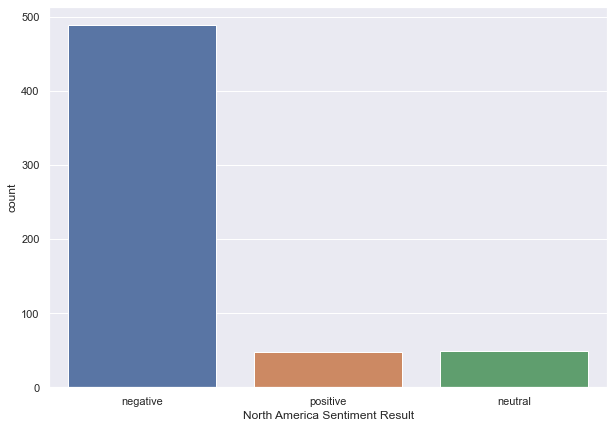

In [507]:
#NA Counterplot of sentiment
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=NA_Cleaned)
ax.set(xlabel='North America Sentiment Result')

*Asia*

In [508]:
#Asia
sia = SentimentIntensityAnalyzer()
AS_Cleaned[['polarity', 'subjectivity']] = AS_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(AS_Cleaned['text']):
  ps = sia.polarity_scores(s)
  AS_Cleaned.loc[index,['neg']] = ps['neg']
  AS_Cleaned.loc[index,['neu']] = ps['neu']
  AS_Cleaned.loc[index,['pos']] = ps['pos']
  AS_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    AS_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    AS_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    AS_Cleaned.loc[index,['sentiment']] = 'neutral'
   
AS_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words,temp_list,polarity,subjectivity,neg,neu,pos,compound,sentiment
0,@therealnaomib Don't hate the criminal.Hate th...,0,0,hate criminalhate crime,No hashtags,"[hate, criminalhate, crime]",-0.800000,0.900000,0.304,0.435,0.261,-0.1285,negative
1,@vijaythottathil He should be charged under UA...,0,2,charge uapa hate speech muslim genocide congre...,No hashtags,"[charge, uapa, hate, speech, muslim, genocide,...",-0.800000,0.900000,0.244,0.756,0.000,-0.6705,negative
2,Criminal crime minister\nWe hate\n#ForeignFund...,0,0,criminal crime minister hate foreignfundedcrim...,#foreignfundedcrimeminister,"[criminal, crime, minister, hate, foreignfunde...",-0.600000,0.725000,0.779,0.221,0.000,-0.8910,negative
3,We should hate both crime and criminals. The o...,5,5,hate crime criminals make law talent killed he,No hashtags,"[hate, crime, criminals, make, law, talent, ki...",-0.500000,0.450000,0.423,0.495,0.082,-0.9246,negative
4,@mr_mayank May be now he would be charged by t...,0,0,would charge government hate speech previous c...,No hashtags,"[would, charge, government, hate, speech, prev...",-0.483333,0.533333,0.224,0.776,0.000,-0.6705,negative


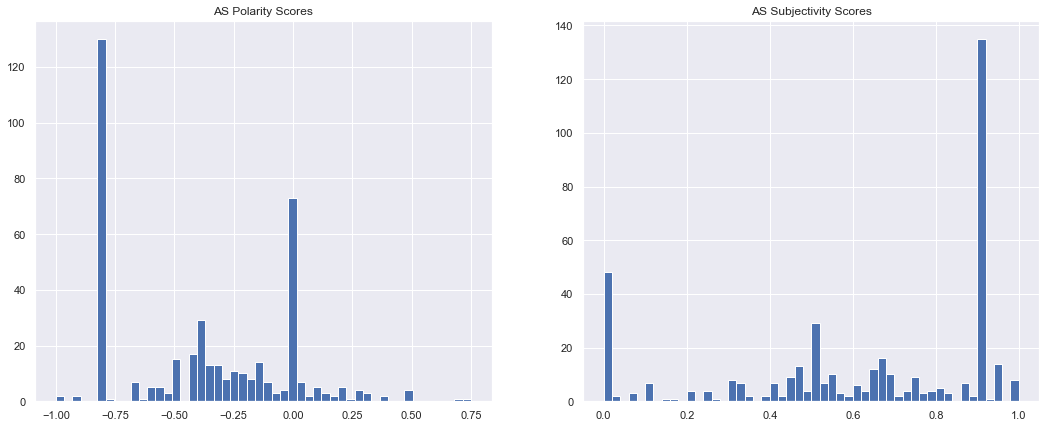

In [509]:
#AS Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(AS_Cleaned["polarity"], bins = n_bins)
ax1.set_title('AS Polarity Scores')
ax2.hist(AS_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('AS Subjectivity Scores')
plt.show()

[Text(0.5, 0, 'Asia Sentiment Result')]

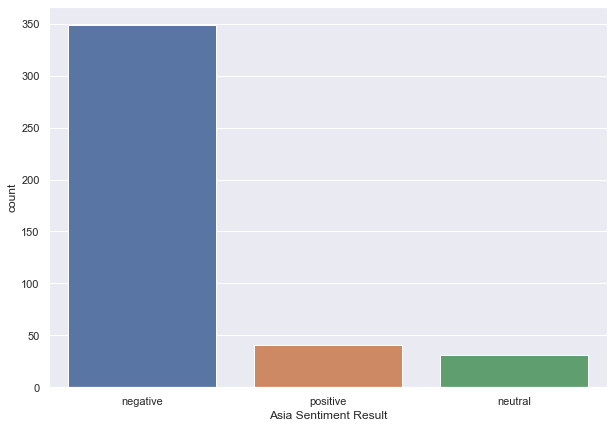

In [510]:
#AS Counterplot of sentiment
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=AS_Cleaned)
ax.set(xlabel='Asia Sentiment Result')